# EGTA Framework Exploration

This notebook demonstrates how to use the Empirical Game-Theoretic Analysis (EGTA) framework to explore strategic interactions between agents deciding how to allocate their trading between traditional CDA markets and the MELO mechanism.

## Overview

1. Basic EGTA setup and running experiments
2. Analyzing equilibria and visualizing results
3. Parameter sweeps to understand how market conditions affect strategy selection
4. Advanced techniques for exploring larger strategy spaces

## 1. Setup and Imports

In [24]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional
from tqdm.notebook import tqdm
import fix_path
import widgetsnbextension

"""
Example code to fix import issues in the egta_exploration.ipynb notebook.

Copy the following code to the first cell of your notebook to fix
the 'No module named marketsim' error.
"""
import os
import sys
import json

# FIX PATH CONFIGURATION: Add the project root to Python path
notebook_dir = os.getcwd()  # Current working directory

# Check if we're in the examples directory
if notebook_dir.endswith('examples'):
    # We're in the examples directory, so parent is project root
    project_root = os.path.dirname(notebook_dir)
else:
    # Find the project root by looking for marketsim directory
    project_root = notebook_dir
    while not os.path.exists(os.path.join(project_root, 'marketsim')) and project_root != '/':
        project_root = os.path.dirname(project_root)
        
    if not os.path.exists(os.path.join(project_root, 'marketsim')):
        # Fallback - try parent of current directory
        project_root = os.path.dirname(notebook_dir)

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

# Debug information
print(f"Current working directory: {notebook_dir}")
print(f"Project root directory: {project_root}")
print(f"sys.path: {sys.path[0]}")

# Try importing fix_path as a fallback
try:
    import fix_path
    fix_path.add_project_root_to_path()
except ImportError:
    print("Could not import fix_path module, using direct path configuration")

# Now test if marketsim can be imported
try:
    import marketsim
    print("Successfully imported marketsim module")
except ImportError as e:
    print(f"Error importing marketsim: {e}")
    print("Please make sure marketsim is installed or the path is correctly set")

# Rest of your imports should work now
from marketsim.egta.egta import EGTA
from marketsim.egta.simulators.melo_wrapper import MeloSimulator
from marketsim.egta.schedulers.dpr import DPRScheduler
from marketsim.egta.schedulers.random import RandomScheduler
from marketsim.egta.utils.visualization import (
    plot_equilibria, 
    plot_strategy_frequency, 
    plot_payoff_matrix,
    plot_regret_landscape,
    create_visualization_report
)
from marketsim.egta.core.game import Game
from marketsim.egta.solvers.equilibria import replicator_dynamics, quiesce, regret

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Current working directory: /Users/gabesmithline/Desktop/SRG/melo_project/examples
Project root directory: /Users/gabesmithline/Desktop/SRG/melo_project
sys.path: /Users/gabesmithline/Desktop/SRG/melo_project
/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Successfully imported marketsim module


In [25]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## 2. Basic EGTA Experiment

Let's run a basic EGTA experiment to analyze how agents allocate trading between CDA and MELO markets.

In [26]:
# Create output directory
output_dir = 'results/egta_notebook'
os.makedirs(output_dir, exist_ok=True)

In [27]:
# Create MELO simulator with default parameters
simulator = MeloSimulator(
    num_strategic=10,  # Number of strategic MOBI agents
    sim_time=100,   # Simulation time horizon
    lam=0.1,         # Arrival rate
    mean=100,        # Mean fundamental value
    r=0.05,          # Mean reversion rate
    q_max=10,        # Maximum inventory
    holding_period=1, # MELO holding period
    reps=100          # Number of simulation repetitions per profile
)

# Get available strategies
strategies = simulator.get_strategies()
print(f"Available strategies: {strategies}")

# Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

Available strategies: ['MELO_100_0', 'MELO_0_100']

Strategy parameters:
  MELO_100_0: CDA=1.00, MELO=0.00
  MELO_0_100: CDA=0.00, MELO=1.00


In [28]:
# Create DPR scheduler with reduction
scheduler = DPRScheduler(
    strategies=strategies,
    num_players=10,           # Full game has 10 players (N)
    reduction_size=4,         # Reduced game has 4 players (n)
    subgame_size=min(3, len(strategies)),
    batch_size=5,
    seed=42
)

# Print information about the scaling
print(f"DPR Scaling Info: {scheduler.get_scaling_info()}")
# Expected output: DPR Scaling Info: {'full_game_players'
# Create EGTA framework
egta = EGTA(
    simulator=simulator,
    scheduler=scheduler,
    device="cpu",     # Use CPU for computation
    output_dir=output_dir,
    max_profiles=1000,   # Maximum number of profiles to simulate
    seed=42           # Random seed for reproducibility
)

DPR Scaling Info: {'full_game_players': 10, 'reduced_game_players': 4, 'scaling_factor': 3.0, 'is_reduced': True}


In [29]:
# Run EGTA (this may take some time)
print("Starting EGTA experiment...")
print(f"Analyzing market allocation strategies: {strategies}")

game = egta.run(
    max_iterations=100, 
    profiles_per_iteration=100,  
    save_frequency=1,   
    verbose=True         
)

print("\nEGTA experiment completed!")

Starting EGTA experiment...
Analyzing market allocation strategies: ['MELO_100_0', 'MELO_0_100']

Iteration 1/100
Simulating 5 profiles...
Simulating profile 1/5: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_0_100']


100%|██████████| 100/100 [00:02<00:00, 39.45it/s]


Simulating profile 2/5: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 100/100 [00:02<00:00, 34.67it/s]


Simulating profile 3/5: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


  7%|▋         | 7/100 [00:00<00:01, 59.71it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 464.6801472121159
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -2323.4007360605797
MELO Trade: Agent 16, Side -1, Quantity 5, Price 464.6801472121159
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2323.4007360605797
MELO Trade: Agent 17, Side 1, Quantity 5, Price 464.6801472121159
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2323.4007360605797
MELO Trade: Agent 18, Side -1, Quantity 5, Price 464.6801472121159
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2323.4007360605797
MELO Trade: Agent 17, Side 1, Quantity 5, Price 53.843449422253386
Agent 17 MELO Profit before trade: -2323.4007360605797
Agent 17 MELO Profit after trade: -2592.6179831718464
MELO Trade: Agent 15, Side -1, Quantity 5, Price 53.843449422253386
Agent 15 MELO Profit before trade: -2323.4007360605797
Agent 15 MELO Profit after trade: -2054.183488949313
MELO Trade: Agent 18

 22%|██▏       | 22/100 [00:00<00:01, 67.68it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -34.9782263786158
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 174.891131893079
MELO Trade: Agent 16, Side -1, Quantity 5, Price -34.9782263786158
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -174.891131893079
MELO Trade: Agent 16, Side 1, Quantity 5, Price 486.9205027974497
Agent 16 MELO Profit before trade: -174.891131893079
Agent 16 MELO Profit after trade: -2609.4936458803277
MELO Trade: Agent 15, Side -1, Quantity 5, Price 486.9205027974497
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 2434.6025139872486
MELO Trade: Agent 18, Side 1, Quantity 5, Price 340.50131730593256
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1702.5065865296629
MELO Trade: Agent 17, Side -1, Quantity 5, Price 340.50131730593256
Agent 17 MELO Profit before trade: 174.891131893079
Agent 17 MELO Profit after trade: 1877.397718422742
MELO Trade: Agent 15, Side 1, 

 36%|███▌      | 36/100 [00:00<00:00, 67.53it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 132.486339067133
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -662.431695335665
MELO Trade: Agent 15, Side -1, Quantity 5, Price 132.486339067133
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 662.431695335665
MELO Trade: Agent 15, Side 1, Quantity 5, Price -247.85352250464194
Agent 15 MELO Profit before trade: 662.431695335665
Agent 15 MELO Profit after trade: 1901.6993078588748
MELO Trade: Agent 16, Side -1, Quantity 5, Price -247.85352250464194
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1239.2676125232097
MELO Trade: Agent 16, Side 1, Quantity 5, Price -208.33525901671572
Agent 16 MELO Profit before trade: -1239.2676125232097
Agent 16 MELO Profit after trade: -197.59131743963098
MELO Trade: Agent 18, Side -1, Quantity 5, Price -208.33525901671572
Agent 18 MELO Profit before trade: -662.431695335665
Agent 18 MELO Profit after trade: -1704.1079904192438
MELO T

 50%|█████     | 50/100 [00:00<00:00, 64.91it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -231.4902559085967
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1157.4512795429835
MELO Trade: Agent 16, Side -1, Quantity 5, Price -231.4902559085967
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1157.4512795429835
MELO Trade: Agent 15, Side 1, Quantity 5, Price -211.6764418397473
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 1058.3822091987365
MELO Trade: Agent 18, Side -1, Quantity 5, Price -211.6764418397473
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1058.3822091987365
MELO Trade: Agent 17, Side 1, Quantity 5, Price 21.652378732878347
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -108.26189366439174
MELO Trade: Agent 18, Side -1, Quantity 5, Price 21.652378732878347
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 108.26189366439174
MELO Trade: Agent 18, Side 1, Quantity 5, Price 213.

 65%|██████▌   | 65/100 [00:00<00:00, 68.47it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 94.44790185241341
Agent 16 MELO Profit before trade: 3826.6104883207836
Agent 16 MELO Profit after trade: 3354.3709790587163
MELO Trade: Agent 15, Side -1, Quantity 5, Price 94.44790185241341
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 472.23950926206703
MELO Trade: Agent 17, Side 1, Quantity 5, Price 260.5325982559799
Agent 17 MELO Profit before trade: -3826.6104883207836
Agent 17 MELO Profit after trade: -5129.273479600683
MELO Trade: Agent 16, Side -1, Quantity 5, Price 260.5325982559799
Agent 16 MELO Profit before trade: 3354.3709790587163
Agent 16 MELO Profit after trade: 4657.033970338616
MELO Trade: Agent 15, Side 1, Quantity 5, Price 158.4241792544874
Agent 15 MELO Profit before trade: 472.23950926206703
Agent 15 MELO Profit after trade: -319.88138701036996
MELO Trade: Agent 16, Side -1, Quantity 5, Price 158.4241792544874
Agent 16 MELO Profit before trade: 4657.033970338616
Agent 16 MELO Profit after tr

 80%|████████  | 80/100 [00:01<00:00, 69.33it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 182.83161657012943
Agent 15 MELO Profit before trade: -870.6441033209728
Agent 15 MELO Profit after trade: -1784.80218617162
MELO Trade: Agent 17, Side -1, Quantity 5, Price 182.83161657012943
Agent 17 MELO Profit before trade: 1263.1718600091049
Agent 17 MELO Profit after trade: 2177.329942859752
MELO Trade: Agent 15, Side 1, Quantity 5, Price 215.2399785419296
Agent 15 MELO Profit before trade: -1784.80218617162
Agent 15 MELO Profit after trade: -2861.002078881268
MELO Trade: Agent 18, Side -1, Quantity 5, Price 215.2399785419296
Agent 18 MELO Profit before trade: -3535.3195232107373
Agent 18 MELO Profit after trade: -2459.1196305010894
MELO Trade: Agent 18, Side 1, Quantity 5, Price 194.81440598708133
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -974.0720299354066
MELO Trade: Agent 15, Side -1, Quantity 5, Price 194.81440598708133
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 974.07202

 95%|█████████▌| 95/100 [00:01<00:00, 69.75it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 273.1390630996836
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1365.695315498418
MELO Trade: Agent 15, Side -1, Quantity 5, Price 273.1390630996836
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 1365.695315498418
MELO Trade: Agent 18, Side 1, Quantity 5, Price -287.69966635474424
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1438.4983317737212
MELO Trade: Agent 17, Side -1, Quantity 5, Price -287.69966635474424
Agent 17 MELO Profit before trade: -1365.695315498418
Agent 17 MELO Profit after trade: -2804.193647272139
MELO Trade: Agent 16, Side 1, Quantity 5, Price 258.78668432184674
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1293.9334216092336
MELO Trade: Agent 17, Side -1, Quantity 5, Price 258.78668432184674
Agent 17 MELO Profit before trade: -2804.193647272139
Agent 17 MELO Profit after trade: -1510.2602256629054
MELO Trade: Agent 16

100%|██████████| 100/100 [00:01<00:00, 67.60it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price 631.2585716376211
Agent 16 MELO Profit before trade: 1483.0196171604684
Agent 16 MELO Profit after trade: -1673.2732410276371
MELO Trade: Agent 17, Side -1, Quantity 5, Price 631.2585716376211
Agent 17 MELO Profit before trade: -1678.74186566158
Agent 17 MELO Profit after trade: 1477.5509925265255
MELO Trade: Agent 18, Side 1, Quantity 5, Price 346.6520413317477
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1733.2602066587383
MELO Trade: Agent 15, Side -1, Quantity 5, Price 346.6520413317477
Agent 15 MELO Profit before trade: 195.72224850111152
Agent 15 MELO Profit after trade: 1928.98245515985
MELO Trade: Agent 17, Side 1, Quantity 5, Price 129.53761389096323
Agent 17 MELO Profit before trade: 1477.5509925265255
Agent 17 MELO Profit after trade: 829.8629230717094
MELO Trade: Agent 15, Side -1, Quantity 5, Price 129.53761389096323
Agent 15 MELO Profit before trade: 1928.98245515985
Agent 15 MELO Profit after trad

  5%|▌         | 5/100 [00:00<00:01, 49.83it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-400.9410])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2004.7048950195312
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-400.9410])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2004.7048950195312
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-1437.4565])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 7187.28271484375
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-1437.4565])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -7187.28271484375
MELO Trade: Agent 16, Side 1, Quantity 5, Price 97.15240435794229
Agent 16 MELO Profit before trade: -7187.28271484375
Agent 16 MELO Profit after trade: -7673.044736633461
MELO Trade: Agent 18, Side -1, Quantity 5, Price 97.15240435794229
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 485.7620217897114
MELO Trade: Agent 18, Side 1, Quantity

 11%|█         | 11/100 [00:00<00:01, 50.02it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-101.1564])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 505.7818603515625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-101.1564])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -505.7818603515625
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1277.2166])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -6386.082763671875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1277.2166])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 6386.082763671875
MELO Trade: Agent 16, Side 1, Quantity 5, Price -11.049622779963073
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 55.248113899815365
MELO Trade: Agent 18, Side -1, Quantity 5, Price -11.049622779963073
Agent 18 MELO Profit before trade: -6386.082763671875
Agent 18 MELO Profit after trade: -6441.3308775716905
MELO Trade: Agent 18, Side 1, Qua

 17%|█▋        | 17/100 [00:00<00:01, 50.39it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -148.3348452067802
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 741.6742260339009
MELO Trade: Agent 16, Side -1, Quantity 5, Price -148.3348452067802
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -741.6742260339009
MELO Trade: Agent 16, Side 1, Quantity 5, Price -35.634787184745974
Agent 16 MELO Profit before trade: -741.6742260339009
Agent 16 MELO Profit after trade: -563.5002901101711
MELO Trade: Agent 18, Side -1, Quantity 5, Price -35.634787184745974
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -178.17393592372986
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([1400.5461])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -7002.730712890625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1400.5461])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 7002.730712890625
MELO Trade: Agent 17, Side 1, Quant

 23%|██▎       | 23/100 [00:00<00:01, 49.93it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 215.47731278081497
Agent 17 MELO Profit before trade: -1850.406618854761
Agent 17 MELO Profit after trade: -2927.793182758836
MELO Trade: Agent 16, Side -1, Quantity 5, Price 215.47731278081497
Agent 16 MELO Profit before trade: 1850.406618854761
Agent 16 MELO Profit after trade: 2927.793182758836
MELO Trade: Agent 18, Side 1, Quantity 5, Price 701.0650692202279
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -3505.3253461011395
MELO Trade: Agent 17, Side -1, Quantity 5, Price 701.0650692202279
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 3505.3253461011395
MELO Trade: Agent 17, Side 1, Quantity 5, Price 147.60532865974864
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -738.0266432987432
MELO Trade: Agent 16, Side -1, Quantity 5, Price 147.60532865974864
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 738.0266432987432
MELO Trade: Agent 16, Sid

 29%|██▉       | 29/100 [00:00<00:01, 50.85it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([240.8153])
Agent 18 MELO Profit before trade: 5780.9893798828125
Agent 18 MELO Profit after trade: 4576.91276550293
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([240.8153])
Agent 16 MELO Profit before trade: -5780.9893798828125
Agent 16 MELO Profit after trade: -4576.91276550293
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([310.1290])
Agent 16 MELO Profit before trade: -4576.91276550293
Agent 16 MELO Profit after trade: -6127.557907104492
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([310.1290])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1550.6451416015625
MELO Trade: Agent 17, Side 1, Quantity 5, Price -321.66724145155786
Agent 17 MELO Profit before trade: 1550.6451416015625
Agent 17 MELO Profit after trade: 3158.981348859352
MELO Trade: Agent 16, Side -1, Quantity 5, Price -321.66724145155786
Agent 16 MELO Profit before trade: -6127.557907104492
Agent 16 MELO Profit afte

 35%|███▌      | 35/100 [00:00<00:01, 49.53it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 180.73387782260954
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -903.6693891130477
MELO Trade: Agent 18, Side -1, Quantity 5, Price 180.73387782260954
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 903.6693891130477
MELO Trade: Agent 16, Side 1, Quantity 5, Price -599.0962561977232
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2995.4812809886157
MELO Trade: Agent 18, Side -1, Quantity 5, Price -599.0962561977232
Agent 18 MELO Profit before trade: 903.6693891130477
Agent 18 MELO Profit after trade: -2091.811891875568
MELO Trade: Agent 16, Side 1, Quantity 5, Price -123.64216275516719
Agent 16 MELO Profit before trade: 2995.4812809886157
Agent 16 MELO Profit after trade: 3613.6920947644517
MELO Trade: Agent 18, Side -1, Quantity 5, Price -123.64216275516719
Agent 18 MELO Profit before trade: -2091.811891875568
Agent 18 MELO Profit after trade: -2710.022705651404
MELO

 40%|████      | 40/100 [00:00<00:01, 47.48it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -789.0065290935219
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 3945.032645467609
MELO Trade: Agent 17, Side -1, Quantity 5, Price -789.0065290935219
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3945.032645467609
MELO Trade: Agent 17, Side 1, Quantity 5, Price -47.38913559497354
Agent 17 MELO Profit before trade: -3945.032645467609
Agent 17 MELO Profit after trade: -3708.0869674927417
MELO Trade: Agent 18, Side -1, Quantity 5, Price -47.38913559497354
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -236.9456779748677
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1666.1163])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -8330.581665039062
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1666.1163])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 8330.581665039062
MELO Trade: Agent 17, Side 1, Quantit

 46%|████▌     | 46/100 [00:00<00:01, 48.76it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-944.5322])
Agent 18 MELO Profit before trade: -1304.1500854492188
Agent 18 MELO Profit after trade: 3418.5110473632812
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-944.5322])
Agent 17 MELO Profit before trade: 306.15081787109375
Agent 17 MELO Profit after trade: -4416.510314941406
MELO Trade: Agent 16, Side 1, Quantity 5, Price 69.60868923532118
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -348.0434461766059
MELO Trade: Agent 18, Side -1, Quantity 5, Price 69.60868923532118
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 348.0434461766059
MELO Trade: Agent 17, Side 1, Quantity 5, Price 343.4322300477449
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1717.1611502387245
MELO Trade: Agent 18, Side -1, Quantity 5, Price 343.4322300477449
Agent 18 MELO Profit before trade: 348.0434461766059
Agent 18 MELO Profit after trade: 2065.2045964153303
MELO T

 51%|█████     | 51/100 [00:01<00:01, 48.98it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-335.6780])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1678.3901977539062
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-335.6780])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1678.3901977539062
MELO Trade: Agent 16, Side 1, Quantity 5, Price 328.5997093520766
Agent 16 MELO Profit before trade: 1678.3901977539062
Agent 16 MELO Profit after trade: 35.39165099352317
MELO Trade: Agent 18, Side -1, Quantity 5, Price 328.5997093520766
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1642.998546760383
MELO Trade: Agent 17, Side 1, Quantity 5, Price 464.0503270346085
Agent 17 MELO Profit before trade: -1678.3901977539062
Agent 17 MELO Profit after trade: -3998.6418329269486
MELO Trade: Agent 16, Side -1, Quantity 5, Price 464.0503270346085
Agent 16 MELO Profit before trade: 35.39165099352317
Agent 16 MELO Profit after trade: 2355.6432861665653
MELO T

 57%|█████▋    | 57/100 [00:01<00:00, 49.56it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -487.71809523523837
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2438.5904761761917
MELO Trade: Agent 17, Side -1, Quantity 5, Price -487.71809523523837
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2438.5904761761917
MELO Trade: Agent 18, Side 1, Quantity 5, Price 180.76570607326136
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -903.8285303663067
MELO Trade: Agent 16, Side -1, Quantity 5, Price 180.76570607326136
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 903.8285303663067
MELO Trade: Agent 16, Side 1, Quantity 5, Price -252.2551825893609
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1261.2759129468045
MELO Trade: Agent 18, Side -1, Quantity 5, Price -252.2551825893609
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1261.2759129468045
MELO Trade: Agent 16, Side 1, Quantity 5, Price -8.2

 63%|██████▎   | 63/100 [00:01<00:00, 50.01it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 577.1318380549885
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2885.6591902749424
MELO Trade: Agent 18, Side -1, Quantity 5, Price 577.1318380549885
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2885.6591902749424


 69%|██████▉   | 69/100 [00:01<00:00, 49.92it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 320.6039723807179
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1603.0198619035896
MELO Trade: Agent 16, Side -1, Quantity 5, Price 320.6039723807179
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1603.0198619035896
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([660.4736])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -3302.3681640625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([660.4736])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 3302.3681640625
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([678.5820])
Agent 17 MELO Profit before trade: 3302.3681640625
Agent 17 MELO Profit after trade: -90.5419921875
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([678.5820])
Agent 16 MELO Profit before trade: -3302.3681640625
Agent 16 MELO Profit after trade: 90.5419921875
MELO Trade: Agent 17, Side 1, Quantity 5,

 80%|████████  | 80/100 [00:01<00:00, 31.97it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([477.0004])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2385.0018310546875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([477.0004])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2385.0018310546875
MELO Trade: Agent 16, Side 1, Quantity 5, Price 409.51709665968053
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2047.5854832984028
MELO Trade: Agent 17, Side -1, Quantity 5, Price 409.51709665968053
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2047.5854832984028
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([5.4824])
Agent 17 MELO Profit before trade: 2047.5854832984028
Agent 17 MELO Profit after trade: 2020.1732785559711
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([5.4824])
Agent 16 MELO Profit before trade: -2047.5854832984028
Agent 16 MELO Profit after trade: -2020.1732785559711
MELO Trade: Agent 16,

 92%|█████████▏| 92/100 [00:02<00:00, 40.44it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -14.334677926747219
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 71.6733896337361
MELO Trade: Agent 16, Side -1, Quantity 5, Price -14.334677926747219
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -71.6733896337361
MELO Trade: Agent 18, Side 1, Quantity 5, Price 110.11524171131433
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -550.5762085565716
MELO Trade: Agent 16, Side -1, Quantity 5, Price 110.11524171131433
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 550.5762085565716
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-154.2384])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 771.1920166015625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-154.2384])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -771.1920166015625
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([

100%|██████████| 100/100 [00:02<00:00, 43.50it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([549.3302])
Agent 16 MELO Profit before trade: 10398.9941197816
Agent 16 MELO Profit after trade: 7652.343118805038
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([549.3302])
Agent 18 MELO Profit before trade: -5851.8946377190205
Agent 18 MELO Profit after trade: -3105.243636742458
MELO Trade: Agent 17, Side 1, Quantity 5, Price 609.2235716596138
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3046.1178582980688
MELO Trade: Agent 16, Side -1, Quantity 5, Price 609.2235716596138
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 3046.1178582980688
MELO Trade: Agent 16, Side 1, Quantity 5, Price 835.4054347645229
Agent 16 MELO Profit before trade: 3046.1178582980688
Agent 16 MELO Profit after trade: -1130.909315524546
MELO Trade: Agent 18, Side -1, Quantity 5, Price 835.4054347645229
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 4177.027173822615
MELO Trade

  0%|          | 0/100 [00:00<?, ?it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([553.1082])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2765.540771484375


 10%|█         | 10/100 [00:00<00:02, 44.46it/s]

MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([553.1082])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2765.540771484375
MELO Trade: Agent 18, Side 1, Quantity 5, Price 119.77569695561988
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -598.8784847780994
MELO Trade: Agent 17, Side -1, Quantity 5, Price 119.77569695561988
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 598.8784847780994
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([2345.0381])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -11725.1904296875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([2345.0381])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 11725.1904296875
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([179.8786])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -899.3930053710938
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1

 20%|██        | 20/100 [00:00<00:01, 43.84it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 449.0791934174043
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2245.3959670870217
MELO Trade: Agent 18, Side -1, Quantity 5, Price 449.0791934174043
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2245.3959670870217
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([989.9580])
Agent 18 MELO Profit before trade: 2245.3959670870217
Agent 18 MELO Profit after trade: -2704.3940719754783
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([989.9580])
Agent 17 MELO Profit before trade: -2245.3959670870217
Agent 17 MELO Profit after trade: 2704.3940719754783
MELO Trade: Agent 17, Side 1, Quantity 5, Price -267.35072779099755
Agent 17 MELO Profit before trade: 2704.3940719754783
Agent 17 MELO Profit after trade: 4041.147710930466
MELO Trade: Agent 18, Side -1, Quantity 5, Price -267.35072779099755
Agent 18 MELO Profit before trade: -2704.3940719754783
Agent 18 MELO Profit after trade: -40

 25%|██▌       | 25/100 [00:00<00:01, 44.08it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1605.6981])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -8028.4906005859375
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1605.6981])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 8028.4906005859375
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1285.9678])
Agent 18 MELO Profit before trade: 8028.4906005859375
Agent 18 MELO Profit after trade: 1598.6517333984375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1285.9678])
Agent 17 MELO Profit before trade: -8028.4906005859375
Agent 17 MELO Profit after trade: -1598.6517333984375
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-59.8195])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 299.0972900390625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-59.8195])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -299.0972900390625
MELO Trade: Age

 35%|███▌      | 35/100 [00:00<00:01, 37.74it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([121.7395])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -608.6977386474609
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([121.7395])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 608.6977386474609
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1821.2944])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 9106.47216796875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1821.2944])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -9106.47216796875
MELO Trade: Agent 18, Side 1, Quantity 5, Price -712.7282098195666
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 3563.641049097833
MELO Trade: Agent 17, Side -1, Quantity 5, Price -712.7282098195666
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3563.641049097833
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([

 45%|████▌     | 45/100 [00:01<00:01, 41.13it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([158.0437])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -790.2183532714844
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([158.0437])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 790.2183532714844
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([809.7185])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -4048.592529296875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([809.7185])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 4048.592529296875
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1941.7727])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 9708.863525390625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1941.7727])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -9708.863525390625
MELO Trade: Agent 18, Side 1, Quantity 5, Price 413.86

 55%|█████▌    | 55/100 [00:01<00:01, 42.92it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-515.1565])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2575.782470703125
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-515.1565])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2575.782470703125
MELO Trade: Agent 17, Side 1, Quantity 5, Price -1080.1837547129792
Agent 17 MELO Profit before trade: 2575.782470703125
Agent 17 MELO Profit after trade: 7976.701244268021
MELO Trade: Agent 18, Side -1, Quantity 5, Price -1080.1837547129792
Agent 18 MELO Profit before trade: -2575.782470703125
Agent 18 MELO Profit after trade: -7976.701244268021
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([515.3171])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2576.585693359375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([515.3171])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2576.585693359375
MELO Trade: Agent 18,

 65%|██████▌   | 65/100 [00:01<00:00, 44.12it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 334.10188409332284
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1670.5094204666143
MELO Trade: Agent 17, Side -1, Quantity 5, Price 334.10188409332284
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1670.5094204666143
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([359.5956])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1797.9779052734375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([359.5956])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1797.9779052734375
MELO Trade: Agent 17, Side 1, Quantity 5, Price -19.93272303934492
Agent 17 MELO Profit before trade: 1797.9779052734375
Agent 17 MELO Profit after trade: 1897.641520470162
MELO Trade: Agent 18, Side -1, Quantity 5, Price -19.93272303934492
Agent 18 MELO Profit before trade: -1797.9779052734375
Agent 18 MELO Profit after trade: -1897.641520470162
MELO Trade: Agent 1

 75%|███████▌  | 75/100 [00:01<00:00, 44.31it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-180.5249])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 902.6243591308594
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-180.5249])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -902.6243591308594
MELO Trade: Agent 18, Side 1, Quantity 5, Price -580.5693988530346
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2902.846994265173
MELO Trade: Agent 17, Side -1, Quantity 5, Price -580.5693988530346
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2902.846994265173
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-770.3218])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 3851.6091918945312
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-770.3218])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3851.6091918945312
MELO Trade: Agent 18, Side 1, Quantity 5, Price 177.

 85%|████████▌ | 85/100 [00:01<00:00, 45.02it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-170.0995])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 850.4977416992188
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-170.0995])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -850.4977416992188
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1075.6222])
Agent 17 MELO Profit before trade: -850.4977416992188
Agent 17 MELO Profit after trade: -6228.608703613281
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1075.6222])
Agent 18 MELO Profit before trade: 850.4977416992188
Agent 18 MELO Profit after trade: 6228.608703613281
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1021.3248])
Agent 18 MELO Profit before trade: 6228.608703613281
Agent 18 MELO Profit after trade: 1121.98486328125
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1021.3248])
Agent 17 MELO Profit before trade: -6228.608703613281
Agent 17 MELO Profit after trade: -1121.

 95%|█████████▌| 95/100 [00:02<00:00, 44.51it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 713.3118334895205
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3566.5591674476027
MELO Trade: Agent 18, Side -1, Quantity 5, Price 713.3118334895205
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 3566.5591674476027
MELO Trade: Agent 18, Side 1, Quantity 5, Price -270.8328270552702
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1354.1641352763509
MELO Trade: Agent 17, Side -1, Quantity 5, Price -270.8328270552702
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1354.1641352763509
MELO Trade: Agent 17, Side 1, Quantity 5, Price -363.55287903448533
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1817.7643951724267
MELO Trade: Agent 18, Side -1, Quantity 5, Price -363.55287903448533
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1817.7643951724267
MELO Trade: Agent 18, Side 1, Quantity 5, Price tens

100%|██████████| 100/100 [00:02<00:00, 42.89it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 540.4069478433382
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2702.0347392166914
MELO Trade: Agent 17, Side -1, Quantity 5, Price 540.4069478433382
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2702.0347392166914
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([330.8021])
Agent 18 MELO Profit before trade: -2702.0347392166914
Agent 18 MELO Profit after trade: -4356.045206745988
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([330.8021])
Agent 17 MELO Profit before trade: 2702.0347392166914
Agent 17 MELO Profit after trade: 4356.045206745988
Simulation completed in 11.54 seconds

Payoff data from simulation:
  Profile: MELO_100_0, Avg Payoff: 84586.8981, Payoffs: [110214.1988671875, 116627.434453125, 111505.95890625, 0.0]
  Profile: MELO_100_0, Avg Payoff: 131173.2306, Payoffs: [126688.5321484375, 132891.224453125, 129519.421171875, 135593.74453125]
  Profile: MELO_0_100, 

## 3. Analyzing Equilibria

Now let's analyze the equilibria found by the EGTA process.

In [39]:
# Analyze equilibria
analysis = egta.analyze_equilibria(verbose=True)

# Save analysis
with open(os.path.join(output_dir, 'analysis.json'), 'w') as f:
    json.dump(analysis, f, indent=2)


Equilibria Analysis
Number of equilibria: 1
Average regret: 0.000000
Average support size: 1.00
Support size range: 1 - 1

Top strategies:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


Top strategies by frequency:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


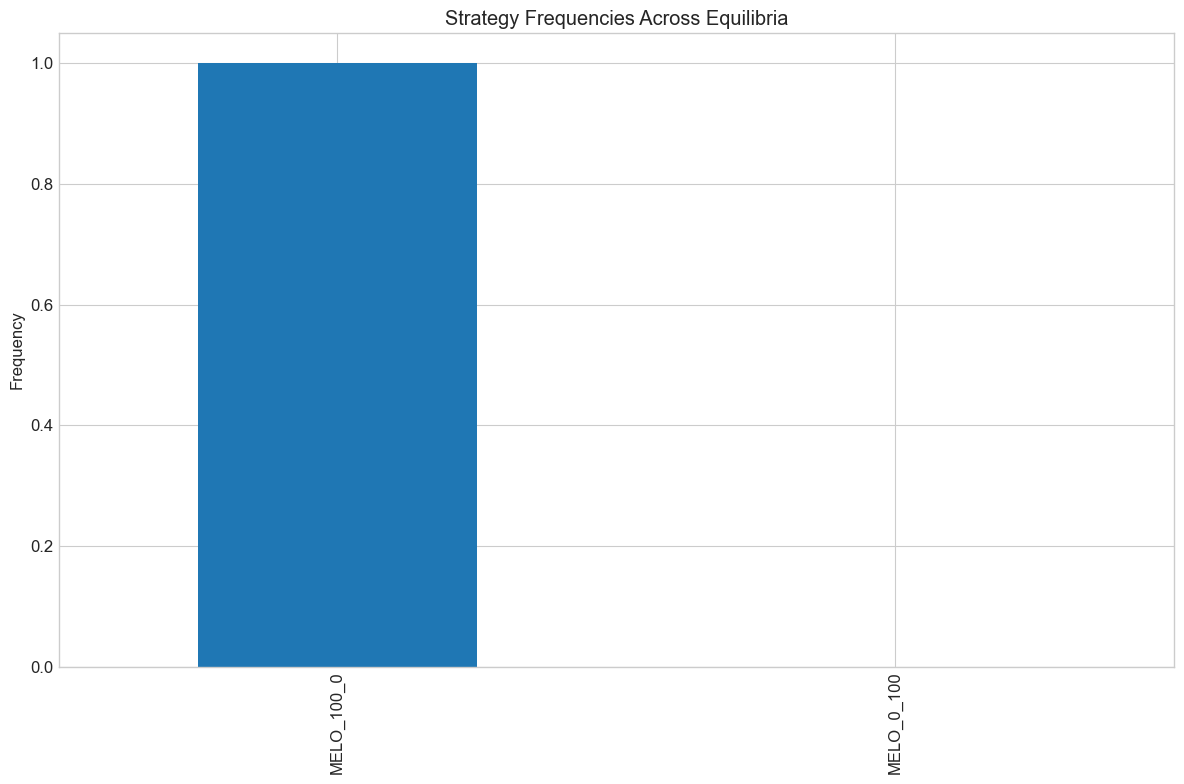

In [40]:
# Print top strategies
print("Top strategies by frequency:")
for strategy, freq in analysis['top_strategies']:
    print(f"  {strategy}: {freq:.4f}")

# Create a bar chart of strategy frequencies
strategy_freqs = pd.Series(analysis['strategy_frequencies'])
strategy_freqs.sort_values(ascending=False).plot(kind='bar')
plt.title('Strategy Frequencies Across Equilibria')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  

## 4. Visualizing Results

## TODO FIX THIS

In [32]:
# Plot the equilibria as a heatmap
'''
plot_equilibria(
    game=game,
    equilibria=egta.equilibria,
    output_file=os.path.join(output_dir, 'equilibria.png'),
    show=True
)
'''

"\nplot_equilibria(\n    game=game,\n    equilibria=egta.equilibria,\n    output_file=os.path.join(output_dir, 'equilibria.png'),\n    show=True\n)\n"

In [33]:
# Plot strategy frequency
'''
plot_strategy_frequency(
    equilibria=egta.equilibria,
    strategy_names=game.strategy_names,
    output_file=os.path.join(output_dir, 'strategy_frequency.png'),
    show=True
)
'''

"\nplot_strategy_frequency(\n    equilibria=egta.equilibria,\n    strategy_names=game.strategy_names,\n    output_file=os.path.join(output_dir, 'strategy_frequency.png'),\n    show=True\n)\n"

In [34]:
# Plot payoff matrix
''''
plot_payoff_matrix(
    game=game,
    output_file=os.path.join(output_dir, 'payoff_matrix.png'),
    show=True
)
'''

"'\nplot_payoff_matrix(\n    game=game,\n    output_file=os.path.join(output_dir, 'payoff_matrix.png'),\n    show=True\n)\n"

In [35]:
# Plot regret landscapes for pairs of strategies
# This helps visualize where the equilibria are located
''''
if len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies
    for i in range(len(game.strategy_names)):
        for j in range(i+1, len(game.strategy_names)):
            plot_regret_landscape(
                game=game,
                strategies=[game.strategy_names[i], game.strategy_names[j]],
                resolution=50,  # Reduced resolution for speed
                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),
                show=True
            )
'''

"'\nif len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies\n    for i in range(len(game.strategy_names)):\n        for j in range(i+1, len(game.strategy_names)):\n            plot_regret_landscape(\n                game=game,\n                strategies=[game.strategy_names[i], game.strategy_names[j]],\n                resolution=50,  # Reduced resolution for speed\n                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),\n                show=True\n            )\n"

In [36]:
# Create a comprehensive visualization report
'''
vis_dir = os.path.join(output_dir, 'visualizations')
report_path = create_visualization_report(
    game=game,
    equilibria=egta.equilibria,
    output_dir=vis_dir
)

print(f"Visualization report saved to {report_path}")
print("Open this HTML file in a browser to view the visualization report")
'''

'\nvis_dir = os.path.join(output_dir, \'visualizations\')\nreport_path = create_visualization_report(\n    game=game,\n    equilibria=egta.equilibria,\n    output_dir=vis_dir\n)\n\nprint(f"Visualization report saved to {report_path}")\nprint("Open this HTML file in a browser to view the visualization report")\n'

## 5. Parameter Sweeps

Now let's explore how different market conditions affect the equilibrium strategies by running parameter sweeps.

In [37]:
def run_experiment(holding_period, lam):
    """Run an EGTA experiment with specific parameters."""
    # Create experiment directory
    exp_dir = f"{output_dir}/sweep_h{holding_period}_lam{lam}"
    os.makedirs(exp_dir, exist_ok=True)
    
    # Create simulator with specific parameters
    simulator = MeloSimulator(
        num_players=10,
        sim_time=1000,
        lam=lam,             # Vary arrival rate
        mean=100,
        r=0.05,
        q_max=10,
        holding_period=holding_period,  # Vary holding period
        reps=2  # Use fewer repetitions for speed
    )
    
    # Create scheduler
    scheduler = DPRScheduler(
        strategies=simulator.get_strategies(),
        num_players=simulator.get_num_players(),
        subgame_size=min(4, len(simulator.get_strategies())),
        batch_size=3,
        seed=42
    )
    
    # Create EGTA framework
    egta = EGTA(
        simulator=simulator,
        scheduler=scheduler,
        device="cpu",
        output_dir=exp_dir,
        max_profiles=30,
        seed=42
    )
    
    # Run with fewer iterations for the parameter sweep
    game = egta.run(
        max_iterations=3,
        profiles_per_iteration=3,
        save_frequency=1,
        verbose=False  # Less verbose for parameter sweep
    )
    
    # Analyze equilibria
    analysis = egta.analyze_equilibria(verbose=False)
    
    # Save analysis
    with open(os.path.join(exp_dir, 'analysis.json'), 'w') as f:
        json.dump(analysis, f, indent=2)
    
    return {
        'holding_period': holding_period,
        'lam': lam,
        'equilibria': [(mix.tolist(), float(reg)) for mix, reg in egta.equilibria],
        'strategy_frequencies': analysis['strategy_frequencies'],
        'top_strategies': analysis['top_strategies']
    }

In [38]:
# Define parameter grid
holding_periods = [1, 5, 10]  # Different MELO holding periods
lambdas = [0.05, 0.1, 0.2]    # Different arrival rates

# Run experiments
results = []
for h in holding_periods:
    print(f"Processing holding period: {h}")
    for lam in lambdas:
        print(f"\nRunning experiment with holding_period={h}, lambda={lam}")
        result = run_experiment(h, lam)
        results.append(result)
        print(f"Completed experiment. Found {len(result['equilibria'])} equilibria.")

# Save all results
with open(os.path.join(output_dir, 'parameter_sweep_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

Processing holding period: 1

Running experiment with holding_period=1, lambda=0.05


TypeError: MeloSimulator.__init__() got an unexpected keyword argument 'num_players'

In [ ]:
sweep_df = pd.DataFrame(results)

def get_top_strategy(row):
    if row['top_strategies']:
        return row['top_strategies'][0][0] 
    return None

sweep_df['top_strategy'] = sweep_df.apply(get_top_strategy, axis=1)

pivot = pd.pivot_table(
    sweep_df, 
    values='top_strategy', 
    index='holding_period', 
    columns='lam',
    aggfunc=lambda x: x
)

print("Top strategy by holding period and arrival rate:")
display(pivot)

plt.figure(figsize=(12, 8))
strategies = simulator.get_strategies()

fig, axes = plt.subplots(len(holding_periods), len(lambdas), figsize=(15, 10))
fig.suptitle('Strategy Frequencies by Market Conditions', fontsize=16)

for i, h in enumerate(holding_periods):
    axes[i, 0].set_ylabel(f'Holding Period = {h}')
    
for j, lam in enumerate(lambdas):
    axes[0, j].set_title(f'λ = {lam}')

for i, h in enumerate(holding_periods):
    for j, lam in enumerate(lambdas):
        result = next((r for r in results if r['holding_period'] == h and r['lam'] == lam), None)
        if result:
            freqs = pd.Series(result['strategy_frequencies'])
            freqs.plot(kind='bar', ax=axes[i, j])
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_ylim(0, 1)
            
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_dir, 'parameter_sweep_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Advanced EGTA - Custom Strategy Space

Let's explore how to define and analyze a custom strategy space, with more fine-grained allocation proportions.

In [17]:
class CustomMeloSimulator(MeloSimulator):
    """Extended MeloSimulator with custom strategy space."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # more fine-grained strategy space
        self.strategies = [
            "MELO_100_0",   # 100% CDA, 0% MELO
            "MELO_90_10",   # 90% CDA, 10% MELO
            "MELO_80_20",   # 80% CDA, 20% MELO
            "MELO_70_30",   # 70% CDA, 30% MELO
            "MELO_60_40",   # 60% CDA, 40% MELO
            "MELO_50_50",   # 50% CDA, 50% MELO
            "MELO_40_60",   # 40% CDA, 60% MELO
            "MELO_30_70",   # 30% CDA, 70% MELO
            "MELO_20_80",   # 20% CDA, 80% MELO
            "MELO_10_90",   # 10% CDA, 90% MELO
            "MELO_0_100",   # 0% CDA, 100% MELO
        ]
        
        # strategy parameters
        self.strategy_params = {}
        for strategy in self.strategies:
            # Parse the strategy name to get proportions
            parts = strategy.split('_')
            cda_prop = int(parts[1]) / 100
            melo_prop = int(parts[2]) / 100
            self.strategy_params[strategy] = {
                "cda_proportion": cda_prop,
                "melo_proportion": melo_prop
            }

In [ ]:
custom_output_dir = f"{output_dir}/custom_strategy_space"
os.makedirs(custom_output_dir, exist_ok=True)

custom_simulator = CustomMeloSimulator(
    num_players=10,
    sim_time=1000,
    lam=0.1,
    holding_period=5,
    reps=2  # Use fewer repetitions for speed
)

#Print available strategies
strategies = custom_simulator.get_strategies()
print(f"Available strategies: {strategies}")

#Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = custom_simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

In [19]:
custom_scheduler = RandomScheduler(
    strategies=strategies,
    num_players=custom_simulator.get_num_players(),
    batch_size=5,
    seed=42
)

custom_egta = EGTA(
    simulator=custom_simulator,
    scheduler=custom_scheduler,
    device="cpu",
    output_dir=custom_output_dir,
    max_profiles=40,
    seed=42
)

In [ ]:
print("Starting EGTA experiment with custom strategy space...")
print(f"Analyzing {len(strategies)} different allocation strategies")

custom_game = custom_egta.run(
    max_iterations=4,
    profiles_per_iteration=5,
    save_frequency=1,
    verbose=True
)

print("\nEGTA experiment completed!")

In [ ]:
custom_analysis = custom_egta.analyze_equilibria(verbose=True)

with open(os.path.join(custom_output_dir, 'analysis.json'), 'w') as f:
    json.dump(custom_analysis, f, indent=2)

In [ ]:
custom_vis_dir = os.path.join(custom_output_dir, 'visualizations')
custom_report_path = create_visualization_report(
    game=custom_game,
    equilibria=custom_egta.equilibria,
    output_dir=custom_vis_dir
)

print(f"Visualization report saved to {custom_report_path}")

## 7. Analysis of Optimal Allocation Curve

## TODO, WE MIGHT want some analysis of metrics, stats. 


In [23]:
def run_holding_period_sweep(holding_periods):
    """Run experiments across different holding periods."""
    sweep_results = []
    
    for holding_period in tqdm(holding_periods):
        # Create experiment directory
        exp_dir = f"{output_dir}/holding_sweep_{holding_period}"
        os.makedirs(exp_dir, exist_ok=True)
        
        # Create simulator with specific holding period
        sim = CustomMeloSimulator(
            num_players=10,
            sim_time=1000,
            lam=0.1,
            holding_period=holding_period,
            reps=2
        )
        
        # Create scheduler
        sched = DPRScheduler(
            strategies=sim.get_strategies(),
            num_players=sim.get_num_players(),
            subgame_size=5,  # Use a larger subgame size for more exploration
            batch_size=4,
            seed=42
        )
        
        # Create EGTA framework
        egta_instance = EGTA(
            simulator=sim,
            scheduler=sched,
            device="cpu",
            output_dir=exp_dir,
            max_profiles=30,
            seed=42
        )
        
        # Run EGTA
        game = egta_instance.run(
            max_iterations=3,
            profiles_per_iteration=4,
            save_frequency=1,
            verbose=False
        )
        
        # Analyze equilibria
        analysis = egta_instance.analyze_equilibria(verbose=False)
        
        # Extract CDA proportions from top strategies
        cda_proportions = []
        for eq_mix, _ in egta_instance.equilibria:
            eq_strat_freqs = dict(zip(game.strategy_names, eq_mix.tolist()))
            weighted_cda_prop = 0
            for strat, freq in eq_strat_freqs.items():
                if freq > 0.01:  # Only count strategies with significant probability
                    cda_prop = sim.strategy_params[strat]['cda_proportion']
                    weighted_cda_prop += cda_prop * freq
            cda_proportions.append(weighted_cda_prop)
        
        # Calculate average CDA proportion
        avg_cda_prop = np.mean(cda_proportions) if cda_proportions else None
        
        # Save results
        result = {
            'holding_period': holding_period,
            'avg_cda_proportion': avg_cda_prop,
            'cda_proportions': cda_proportions,
            'num_equilibria': len(egta_instance.equilibria),
            'top_strategies': analysis['top_strategies']
        }
        sweep_results.append(result)
        
    return sweep_results

In [ ]:
# Run a sweep across different holding periods
holding_periods = [1, 2, 3, 5, 7, 10, 15, 20]
holding_sweep_results = run_holding_period_sweep(holding_periods)

# Save results
with open(os.path.join(output_dir, 'holding_period_sweep_results.json'), 'w') as f:
    json.dump(holding_sweep_results, f, indent=2)

In [ ]:
# Create a dataframe from results
holding_df = pd.DataFrame(holding_sweep_results)

# Plot the relationship between holding period and CDA proportion
plt.figure(figsize=(10, 6))
plt.plot(holding_df['holding_period'], holding_df['avg_cda_proportion'], 'o-', linewidth=2, markersize=8)
plt.xlabel('MELO Holding Period')
plt.ylabel('Average CDA Proportion in Equilibrium')
plt.title('Optimal CDA Allocation vs. MELO Holding Period')
plt.grid(True)
plt.ylim(0, 1)
plt.savefig(os.path.join(output_dir, 'optimal_allocation_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display the data
display(holding_df[['holding_period', 'avg_cda_proportion', 'num_equilibria']])